<a href="https://colab.research.google.com/github/boangri/uai-thesis-notebooks/blob/main/notebooks/Reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REINFORCE

In [1]:
!pip install box2d-py

     |████████████████████████████████| 450kB 12.4MB/s 


In [2]:
!pip install pyvirtualdisplay 
!pip install xvfbwrapper 
!apt-get update 
!apt-get install xvfb

  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-cp37-none-any.whl size=5009 sha256=9b5077c8c65cf98117a9f6f09b92ff121cb35390284703344874c86371c40744
  Stored in directory: /root/.cache/pip/wheels/10/f2/61/cacfaf84b352c223761ea8d19616e3b5ac5c27364da72863f0
Successfully built xvfbwrapper
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:10 https://developer

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import glob 
import io 
import base64 
from IPython.display import HTML 
import time 
from IPython import display as ipythondisplay 
from pyvirtualdisplay import Display 
import gym
from gym import wrappers
from gym import logger as gymlogger 
from gym.wrappers import Monitor 
gymlogger.set_level(40)
import json

## Classes & Functions

### PolicyNetwork

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, ALPHA, input_dims, fc1_dims, fc2_dims, n_actions, chkpt_dir, name):
        super().__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, observation):
        state = T.Tensor(observation).to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

### PolicyGradientAgent

In [6]:
class PolicyGradientAgent(object):
    def __init__(self, policyNetwork, GAMMA=0.99):
        self.gamma = GAMMA
        self.reward_memory = []
        self.action_memory = []
        self.policy = policyNetwork

    def choose_action(self, observation):
        probabilities = F.softmax(self.policy.forward(observation), dim=-1)
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)

        h = -(probabilities * T.log(probabilities)).sum()

        return action.item(), h.item()

    def store_rewards(self,reward):
        self.reward_memory.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()
        # Assumes only a single episode for reward_memory
        G = np.zeros_like(self.reward_memory, dtype=np.float64)
        # for t in range(len(self.reward_memory)):
        #     G_sum = 0
        #     discount = 1
        #     for k in range(t, len(self.reward_memory)):
        #         G_sum += self.reward_memory[k] * discount
        #         discount *= self.gamma
        #     G[t] = G_sum

        G_sum = 0.
        for t in range(len(G)-1, -1, -1):
            G_sum *= self.gamma
            G_sum += self.reward_memory[t] 
            G[t] = G_sum
        
        mean = np.mean(G)
        std = np.std(G) if np.std(G) > 0 else 1
        G = (G - mean) / std

        G = T.tensor(G, dtype=T.float).to(self.policy.device)

        loss = 0
        for g, logprob in zip(G, self.action_memory):
            loss += -g * logprob

        loss.backward()
        self.policy.optimizer.step()

        self.action_memory = []
        self.reward_memory = []
        
        return loss.to('cpu').detach().numpy()
        
    def save_model(self):
        self.policy.save_checkpoint()
    
    def load_model(self):
        self.policy.load_checkpoint()

### learn()

In [7]:
def learn(env, agent, n_games, history_file, freq=10):
    scores = []
    for i in range(n_games):
        done = False
        observation = env.reset()
        score = 0
        steps = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            steps += 1
            observation = observation_
        scores.append(score)
        agent.learn()
        if (i + 1) % freq == 0:
            avg_score = np.mean(scores[-100:])
            print('episode ', i + 1, 'score %.1f avg score %.1f steps %d' % (score, avg_score, steps))
        with open(history_file,'a') as h:   
            h.write("%d,%.3f,%d\n" % (i + 1, score, steps)) 
    agent.save_model()

### test()

In [24]:
def test(env, agent, episodes=100):
    total = 0.
    for ep in range(episodes):
        score = 0.
        obs = env.reset()
        done = False
        while not done:
            action, _ = agent.choose_action(obs)
            obs, reward, done, _ = env.step(action)
            score += reward
        if (ep + 1) % 10 == 0:
            print("episode: %d Score: %1.f" % (ep+1, score))
        total += score
    print("Average score %.2f" % (total/episodes))

### video()

In [26]:
display = Display(visible=0, size=(1400, 900))
display.start()

def video(env, agent, dir, seed=42):
    env.seed(seed)
    env = wrap_env(env)
    obs = env.reset()
    done = False
    score = 0.
    while not done:
        env.render()
        action, _ = agent.choose_action(obs)
        obs, reward, done, _ = env.step(action)
        score += reward
    env.close()
    print("Score=%.2f" % score)
    show_video(dir)

def show_video(dir):    
    mp4list = glob.glob(os.path.join(dir, 'video/*.mp4'))
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env):
    env = Monitor(env, os.path.join(dir, 'video'), force=True)
    return env

### plot_history()

In [10]:
def plot_history(path):
    df = pd.read_csv(path + '.csv', header=None, names=('episode', 'score', 'steps', 'loss', 'entropy'))
    x = df.episode
    y = df.score
    y1 = np.zeros_like(y)
    for i in range(len(x)):
        y1[i] = np.mean(y[i-100:i])
    steps = df.steps
    loss = df.loss
    entropy = df.entropy
    plt.figure(figsize=(12,12))
    plt.subplot(2, 1, 1)
    plt.plot(x, y, 'o', markersize=3, label='очки')
    plt.plot(x, y1, color='C1', label='среднее за 100')
    plt.ylabel('Очки')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - очки')
    plt.subplot(2, 1, 2)
    plt.plot(x, entropy, 'o', markersize=3, color='C2', label='entropy')
    plt.ylabel('Средняя энтропия')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - энтропия')
    plt.show()

In [11]:
algo='REINFORCE'
home_dir = os.path.join('/content/drive/MyDrive/Thesys', algo)

## LunarLander-v2

### Гиперпараметры

In [29]:
hp = dict(
    env_name='LunarLander-v2',
    algo='REINFORCE',
    id='04',
    horizon=100,
    avg_reward=1.,
    n_episodes=3000,
    n_steps=200,
    lr=0.0001,
    layers=[256, 256],
)
env_name = hp['env_name']
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, hp['id'])
path = os.path.join(dir, 'history')
!mkdir -p $dir 
with open(os.path.join(dir, "hp.json"), "w") as json_file:
    json.dump(hp, json_file)

### Обучение

In [30]:
n_steps = hp['n_steps']
env = gym.make(env_name)

Nh = hp['horizon']
sf = hp['avg_reward'] * Nh 
gamma = 1 - 1/Nh
n_episodes = hp['n_episodes']
lr = hp['lr']
input_dims = env.observation_space.shape
n_actions = env.action_space.n
scores = []
policyNetwork = PolicyNetwork(ALPHA=lr, input_dims=input_dims, fc1_dims=256, fc2_dims=256, n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=gamma)


In [31]:
%%time
history_file = path + '.csv'
!rm -rf $history_file

freq = 10

for ep in range(n_episodes):
    done = False
    score = 0
    obs = env.reset()
    steps = 0
    avg_entropy = 0.
    while not done:
        action, entropy = agent.choose_action(obs)
        avg_entropy += entropy
        obs_, reward, done, info = env.step(action)
        agent.store_rewards(reward)
        obs = obs_
        score += reward
        steps += 1
    scores.append(score)
    avg_entropy /= steps
    loss = agent.learn() / steps
    if (ep + 1) % freq == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f steps %d loss %.3f entropy %.3f' % (score, avg_score, steps, loss, avg_entropy))
    with open(history_file,'a') as h:   
        h.write("%d,%.3f,%d,%.3f,%.3f\n" % (ep + 1, score, steps, loss, avg_entropy)) 
agent.save_model()

episode  10 score -238.607 avg score -218.640 steps 122 loss 0.008 entropy 1.385
episode  20 score -119.908 avg score -189.404 steps 96 loss -0.005 entropy 1.385
episode  30 score -296.805 avg score -203.099 steps 80 loss 0.007 entropy 1.386
episode  40 score -178.119 avg score -196.508 steps 98 loss 0.002 entropy 1.384
episode  50 score -97.476 avg score -180.099 steps 108 loss 0.001 entropy 1.385
episode  60 score -272.809 avg score -176.273 steps 124 loss 0.007 entropy 1.385
episode  70 score -337.156 avg score -175.426 steps 127 loss -0.009 entropy 1.383
episode  80 score -166.784 avg score -172.514 steps 111 loss -0.001 entropy 1.386
episode  90 score -287.407 avg score -173.537 steps 100 loss -0.024 entropy 1.376
episode  100 score -113.837 avg score -176.850 steps 83 loss 0.004 entropy 1.385
episode  110 score -98.392 avg score -173.424 steps 57 loss -0.003 entropy 1.383
episode  120 score -158.204 avg score -170.628 steps 77 loss 0.003 entropy 1.385
episode  130 score -178.368 

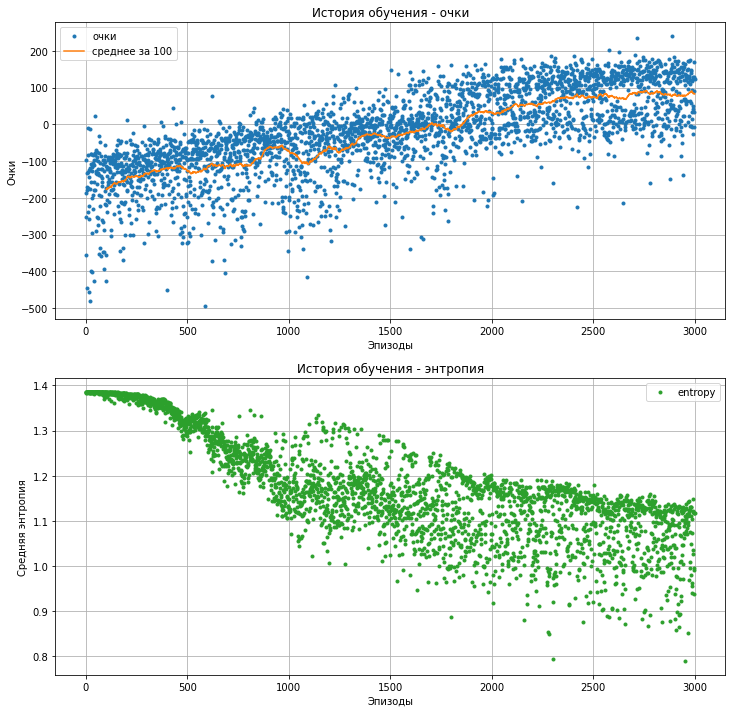

{'algo': 'REINFORCE',
 'avg_reward': 1.0,
 'env_name': 'LunarLander-v2',
 'horizon': 100,
 'id': '04',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 200}

In [32]:
plot_history(path)
hp

### Тестирование

In [33]:
policyNetwork = PolicyNetwork(ALPHA=lr, input_dims=input_dims, fc1_dims=256, fc2_dims=256, n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=gamma)

agent.load_model()

... loading checkpoint ...


In [34]:
%%time
env = gym.make(env_name)
test(env, agent, episodes=100)

episode: 10 Score: -9
episode: 20 Score: -24
episode: 30 Score: 88
episode: 40 Score: 123
episode: 50 Score: 125
episode: 60 Score: 167
episode: 70 Score: 117
episode: 80 Score: 93
episode: 90 Score: 114
episode: 100 Score: 135
Average score 107.87
CPU times: user 2min 49s, sys: 2.2 s, total: 2min 52s
Wall time: 2min 52s


### Video

In [28]:
env = gym.make(env_name)
video(env, agent, dir, seed=42)

Score=217.43


## CartPole-v1

In [15]:
env_name = 'CartPole-v1'
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, "02")
path = os.path.join(dir, 'history')
!mkdir -p $dir 

### Гиперпараметры

In [16]:
hp = dict(
    env_name='CartPole-v1',
    algo='DQN',
    id='02',
    horizon=500,
    avg_reward=1.,
    n_episodes=3000,
    n_steps=500,
    lr=0.0001,
    layers=[1024, 512],
)
env_name = hp['env_name']
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, hp['id'])
path = os.path.join(dir, 'history')
!mkdir -p $dir 
with open(dir + "/hp.json", "w") as json_file:
    json.dump(hp, json_file)

In [17]:
n_steps = hp['n_steps']
env = gym.make(env_name)

Nh = hp['horizon']
sf = hp['avg_reward'] * Nh 
gamma = 1 - 1/Nh
n_episodes = hp['n_episodes']
lr = hp['lr']
input_dims = env.observation_space.shape
n_actions = env.action_space.n
scores = []
policyNetwork = PolicyNetwork(ALPHA=lr, input_dims=input_dims, fc1_dims=hp['layers'][0], fc2_dims=hp['layers'][1], n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=gamma)


### Обучение

In [19]:
%%time
history_file = path + '.csv'
!rm -rf $history_file

freq = 100
for ep in range(n_episodes):
    done = False
    score = 0
    obs = env.reset()
    steps = 0
    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        agent.store_rewards(reward)
        obs = obs_
        score += reward
        steps += 1
    scores.append(score)
    loss = agent.learn()
    if (ep + 1) % freq == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f steps %d loss %.3f' % (score, avg_score, steps, loss))
    with open(history_file,'a') as h:   
        h.write("%d,%.3f,%d\n" % (ep + 1, score, steps)) 
agent.save_model()

episode  100 score 49.000 avg score 68.890 steps 49 loss 2.382
episode  200 score 227.000 avg score 149.870 steps 227 loss 3.000
episode  300 score 212.000 avg score 206.150 steps 212 loss -3.091
episode  400 score 180.000 avg score 223.000 steps 180 loss -5.394
episode  500 score 196.000 avg score 248.030 steps 196 loss -7.455
episode  600 score 130.000 avg score 180.200 steps 130 loss 3.574
episode  700 score 202.000 avg score 289.860 steps 202 loss 1.997
episode  800 score 125.000 avg score 321.970 steps 125 loss -5.683
episode  900 score 201.000 avg score 106.460 steps 201 loss -0.183
episode  1000 score 125.000 avg score 193.140 steps 125 loss -4.882
episode  1100 score 186.000 avg score 171.670 steps 186 loss 4.146
episode  1200 score 98.000 avg score 125.440 steps 98 loss 1.408
episode  1300 score 272.000 avg score 158.310 steps 272 loss 2.062
episode  1400 score 336.000 avg score 445.620 steps 336 loss -2.809
episode  1500 score 231.000 avg score 242.060 steps 231 loss 8.646
ep

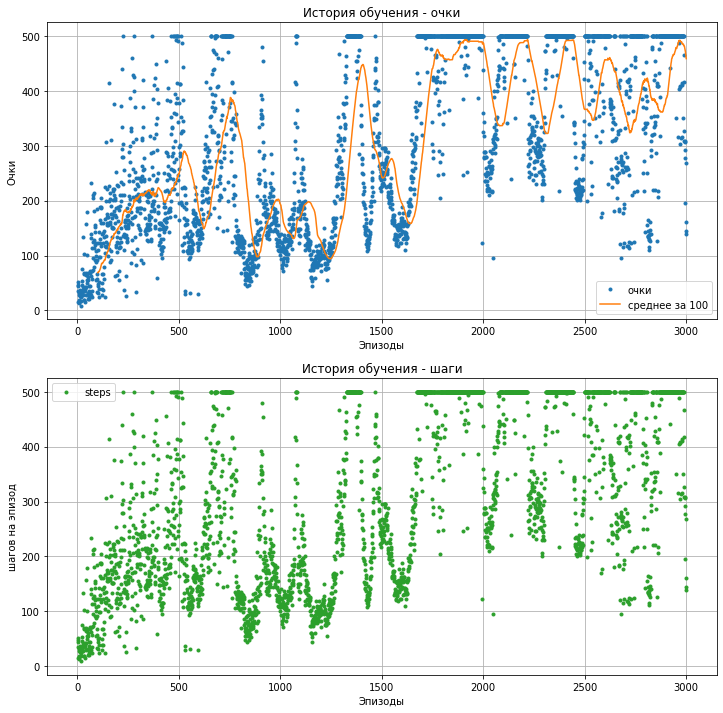

{'algo': 'DQN',
 'avg_reward': 1.0,
 'env_name': 'CartPole-v1',
 'horizon': 500,
 'id': '02',
 'layers': [1024, 512],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 500}

In [21]:
plot_history(path)
hp

In [25]:
policyNetwork = PolicyNetwork(ALPHA=lr, input_dims=input_dims, fc1_dims=hp['layers'][0], fc2_dims=hp['layers'][1], n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=gamma)

### Тестирование

In [26]:
test(env, agent, episodes=100)

episode: 10 Score: 13
episode: 20 Score: 18
episode: 30 Score: 12
episode: 40 Score: 26
episode: 50 Score: 39
episode: 60 Score: 63
episode: 70 Score: 17
episode: 80 Score: 12
episode: 90 Score: 11
episode: 100 Score: 21
Average score 22.15


In [27]:
%%time
env = gym.make(env_name)
episodes = 100
total = 0.
for ep in range(episodes):
    score = 0.
    obs = env.reset()
    done = False
    while not done:
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(action)
        score += reward
    if (ep + 1) % 10 == 0:
        print("episode: %d Score: %1.f" % (ep+1, score))
    total += score
print("Average score %.2f" % (total/episodes))

episode: 10 Score: 14
episode: 20 Score: 16
episode: 30 Score: 23
episode: 40 Score: 13
episode: 50 Score: 16
episode: 60 Score: 12
episode: 70 Score: 15
episode: 80 Score: 11
episode: 90 Score: 30
episode: 100 Score: 14
Average score 21.56
CPU times: user 1.61 s, sys: 42 ms, total: 1.65 s
Wall time: 1.65 s


### Video

In [ ]:
video(env, agent, seed=42)

In [ ]:
env = gym.make(env_name)
env.seed(1)
env = wrap_env(env)
obs = env.reset()
done = False
score = 0.
while not done:
    env.render()
    action = agent.choose_action(obs)
    obs, reward, done, _ = env.step(action)
    score += reward
env.close()
print("Score=%.2f" % score)
show_video()

Score=200.00


## GrandPrix-v0

In [13]:
!pip install gym-grand-prix

     |████████████████████████████████| 11.8MB 13.9MB/s 


In [14]:
import gym_grand_prix
from gym import spaces
from gym_grand_prix.wrappers import GrandPrixWrapper

GrandPrix-v0 version 0.2.3 20.3.2021


### Гиперпараметры

In [21]:
hp = dict(
    env_name='GrandPrix-v0',
    algo='REINFORCE',
    id='06',
    track=3,
    fine=10.,
    horizon=20,
    avg_reward=5.,
    n_episodes=2000,
    n_steps=200,
    lr=0.0003,
    layers=[256, 256],
)
env_name = hp['env_name']
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, hp['id'])
path = os.path.join(dir, 'history')
!mkdir -p $dir 
with open(os.path.join(dir, "hp.json"), "w") as json_file:
    json.dump(hp, json_file)

In [22]:
with open(os.path.join(dir, "hp.json"), "r") as read_file: 
    hp1 = json.load(read_file)
hp1

{'algo': 'REINFORCE',
 'avg_reward': 5.0,
 'env_name': 'GrandPrix-v0',
 'fine': 10.0,
 'horizon': 20,
 'id': '06',
 'layers': [256, 256],
 'lr': 0.0003,
 'n_episodes': 2000,
 'n_steps': 200,
 'track': 3}

In [23]:
fine = hp['fine']
track = hp['track']
n_steps = hp['n_steps']
n_rays = 5
env = gym.make(env_name)
env = GrandPrixWrapper(env, steps_per_episode=n_steps, fine=fine)

options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}

Nh = hp['horizon']
sf = hp['avg_reward'] * Nh 
gamma = 1 - 1/Nh
n_episodes = hp['n_episodes']
lr = hp['lr']
input_dims = env.observation_space.shape
n_actions = env.action_space.n
scores = []
policyNetwork = PolicyNetwork(ALPHA=lr, input_dims=input_dims, fc1_dims=256, fc2_dims=256, n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=gamma)


### Обучение

In [24]:
%%time
history_file = path + '.csv'
!rm -rf $history_file

freq = 2000 // n_steps

obs = env.reset(options=options)
for ep in range(n_episodes):
    done = False
    score = 0
    obs = env.reset()
    collisions = 0
    steps = 0
    avg_entropy = 0.
    while not done:
        action, entropy = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        agent.store_rewards(reward)
        obs = obs_
        score += reward / n_steps
        avg_entropy += entropy / n_steps
        if 'collision' in info and info['collision']:
            collisions += 1
        steps += 1
    scores.append(score)
    loss = agent.learn()
    if (ep + 1) % freq == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f steps %d coll %d loss %.3f avg_entropy %.3f' % (score, avg_score, steps, collisions, loss, avg_entropy))
    with open(history_file,'a') as h:   
        h.write("%d,%.3f,%d,%.3f,%.3f\n" % (ep + 1, score, steps, loss, avg_entropy)) 
agent.save_model()

episode  10 score -1.456 avg score -1.194 steps 200 coll 6 loss -1.139 avg_entropy 1.574
episode  20 score 0.423 avg score -1.107 steps 200 coll 5 loss -4.497 avg_entropy 1.572
episode  30 score -1.253 avg score -1.164 steps 200 coll 7 loss -3.400 avg_entropy 1.559
episode  40 score -1.826 avg score -1.115 steps 200 coll 14 loss -9.944 avg_entropy 1.505
episode  50 score 0.706 avg score -1.005 steps 200 coll 4 loss 11.206 avg_entropy 1.538
episode  60 score -0.452 avg score -0.965 steps 200 coll 6 loss -7.964 avg_entropy 1.461
episode  70 score 0.000 avg score -0.923 steps 200 coll 10 loss -0.053 avg_entropy 1.444
episode  80 score 1.072 avg score -0.872 steps 200 coll 2 loss 3.287 avg_entropy 1.432
episode  90 score 1.251 avg score -0.754 steps 200 coll 3 loss 2.150 avg_entropy 1.411
episode  100 score 2.298 avg score -0.701 steps 200 coll 2 loss -9.251 avg_entropy 1.432
episode  110 score -0.546 avg score -0.553 steps 200 coll 2 loss -5.178 avg_entropy 1.424
episode  120 score -1.096

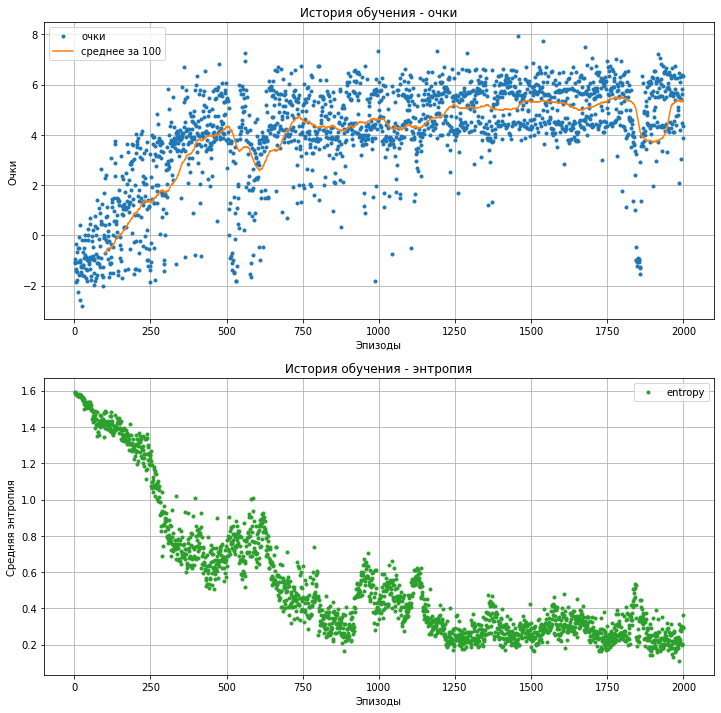

{'algo': 'REINFORCE',
 'avg_reward': 5.0,
 'env_name': 'GrandPrix-v0',
 'fine': 10.0,
 'horizon': 20,
 'id': '06',
 'layers': [256, 256],
 'lr': 0.0003,
 'n_episodes': 2000,
 'n_steps': 200,
 'track': 3}

In [27]:
plot_history(path)
hp

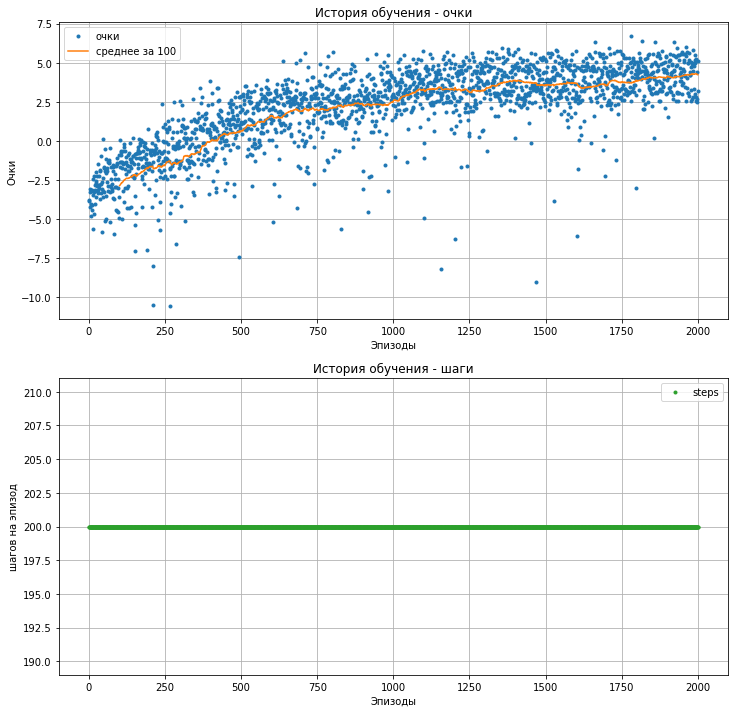

{'algo': 'reinforce',
 'avg_reward': 5.0,
 'env_name': 'GrandPrix-v0',
 'fine': 100.0,
 'horizon': 20,
 'id': '02',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 2000,
 'n_steps': 200,
 'track': 3}

In [ ]:
plot_history(path)
hp

### Тестирование

In [28]:
policyNetwork = PolicyNetwork(ALPHA=lr, input_dims=input_dims, fc1_dims=256, fc2_dims=256, n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=gamma)

agent.load_model()

... loading checkpoint ...


In [29]:
%%time
track = 3
n_rays = 5
n_steps = 2000
env = gym.make(env_name)
env = GrandPrixWrapper(env, fine=0., steps_per_episode=n_steps)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
episodes = 10
total = 0.
total_coll = 0
obs = env.reset(options=options)
v = []
for ep in range(episodes):
    score = 0.
    collisions = 0
    obs = env.reset()
    done = False
    while not done:
        action, _ = agent.choose_action(obs)
        obs, reward, done, info = env.step(action)
        v.append(obs[0])
        score += reward/n_steps
        if 'collision' in info and info['collision']:
            collisions += 1
    if (ep + 1) % 1 == 0:
        print("episode: %d Score: %.3f Collisions: %d" % (ep+1, score, collisions))
    total += score
    total_coll += collisions
print("Average score %.3f Avg collisions: %.3f" % (total/episodes, total_coll/episodes))
v = np.array(v)
print('Vmax:%.3f Vmean:%.3f Vstd:%.3f' % (v.max(), v.mean(), v.std()))

episode: 1 Score: 5.380 Collisions: 41
episode: 2 Score: 5.593 Collisions: 38
episode: 3 Score: 5.424 Collisions: 40
episode: 4 Score: 5.411 Collisions: 41
episode: 5 Score: 5.308 Collisions: 44
episode: 6 Score: 5.527 Collisions: 40
episode: 7 Score: 5.525 Collisions: 40
episode: 8 Score: 5.201 Collisions: 43
episode: 9 Score: 5.644 Collisions: 40
episode: 10 Score: 4.874 Collisions: 43
Average score 5.389 Avg collisions: 41.000
Vmax:3.541 Vmean:1.512 Vstd:0.910
CPU times: user 1min 51s, sys: 634 ms, total: 1min 51s
Wall time: 1min 51s


### Video

In [30]:
track = 3
n_rays = 5
n_steps = 2000
env = gym.make(env_name)
env = GrandPrixWrapper(env, fine=0., steps_per_episode=n_steps )
env = Monitor(env, os.path.join(dir, 'video'), force=True)

options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
    'display': 1
}

obs = env.reset(options=options)
done = False
score = 0.
while not done:
    env.render()
    action, _ = agent.choose_action(obs)
    obs, reward, done, _ = env.step(action)
    score += reward/n_steps
env.close()
print("Score=%.3f" % score)
show_video(dir)
hp

Score=5.147


{'algo': 'REINFORCE',
 'avg_reward': 5.0,
 'env_name': 'GrandPrix-v0',
 'fine': 10.0,
 'horizon': 20,
 'id': '06',
 'layers': [256, 256],
 'lr': 0.0003,
 'n_episodes': 2000,
 'n_steps': 200,
 'track': 3}

#End